In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import regex as re
from matplotlib.legend_handler import HandlerBase
from scipy import stats
from matplotlib.ticker import FuncFormatter
import os
from IPython.display import clear_output
from matplotlib import rcParams
import matplotlib.font_manager as fm


def classify_products(filename):
    """Loads the dataset and classifies the products into entrees, desserts, and drinks.
    Returns the dataframe and the indices of the entrees, desserts, and drinks. Also
    returns the indices of products that belong to multiple groups.
    """
    entree_keywords = np.load("entree_keywords.npy")
    dessert_keywords = np.load("dessert_keywords.npy")
    drink_keywords = np.load("drink_keywords.npy")
    
    df = pd.read_csv(filename)

    product_names = np.array(df["Product Name"].values, dtype=str)

    # Normalize and tokenize the dataset
    normalized_names = [re.sub(r'[^\w\s]', '', name.lower()) for name in product_names]
    all_words = ' '.join(normalized_names).split()
    
    entree_index_list = []
    dessert_index_list = []
    drink_index_list = []
    entree_names_list = []
    dessert_names_list = []
    drink_names_list = []
    multiple_groups_list = []

    for i, row in enumerate(normalized_names):
        group_counter = np.zeros(3, dtype=int)
        
        for keyword in entree_keywords:
            if keyword in row:
                if i not in entree_index_list:
                    entree_index_list.append(i)
                    entree_names_list.append(row)
                    group_counter[0] += 1
        
        for keyword in dessert_keywords:
            if keyword in row:
                if "pancake" in row:
                    continue
                if i not in dessert_index_list:
                    dessert_index_list.append(i)
                    dessert_names_list.append(row)
                    group_counter[1] += 1
        
        for keyword in drink_keywords:
            if keyword in row:
                if i not in drink_index_list:
                    drink_index_list.append(i)
                    drink_names_list.append(row)
                    group_counter[2] += 1
        
        if group_counter.sum() > 1:
            multiple_groups = [i, group_counter.sum()]
            multiple_groups.extend(group_counter)
            multiple_groups_list.append(multiple_groups)
    
    return (df, 
            np.array(entree_index_list), 
            np.array(dessert_index_list), 
            np.array(drink_index_list), 
            np.array(multiple_groups_list))


def get_data_for_products(df, index_list, outlier_threshold=np.inf):
    """Gets the pricing data for the products in the index_list.
    If outlier_threshold is provided, the data will be filtered to exclude
    prices that are less than the outlier_threshold. If outlier_threshold
    is 'choose', the user will be prompted to choose a threshold after
    viewing the data.
    
    Returns the pricing data and the new dataframe with the filtered data.
    """
    
    # Get indices
    new_df = df.iloc[np.array(index_list)]
    
    if outlier_threshold == "choose":
        
        # Drinks Data
        # Get entree_pricing
        pricing = df["Price"].values[np.array(index_list)]
        
        # Sort the pricing
        temp_df = new_df.iloc[new_df['Price'].argsort()][["Product Name", "Price"]]
        # if len(temp_df) > 50:
        #     print(temp_df.iloc[-50:])
        # else:
        #     print(temp_df)
            
        while True:
            outlier_threshold = np.ceil(temp_df["Price"].iloc[-1])

            try:
                outlier_threshold = float(outlier_threshold)
                break
            except Exception as e:
                print("Please enter a valid number.")
        
    # Drinks Data
    # Get entree_pricing
    pricing = df["Price"].values[np.array(index_list)]
    
    outlier_mask = pricing <= outlier_threshold
    pricing = pricing[outlier_mask]
    
    if outlier_threshold != np.inf:  # Make the histogram more readable
        pricing = np.append(pricing, outlier_threshold)
        pricing = np.append(0., pricing)

    # Get indices
    new_df = new_df[outlier_mask]
    
    # Clear the output to make the notebook more readable
    # clear_output()
    
    return pricing, new_df, int(outlier_threshold) if outlier_threshold != np.inf else None


# Custom handler for legend to hide icons
class NoIconHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a transparent line (or dot) for legend
        return [plt.Line2D([], [], color='none')]


# Function to format y-axis ticks as percentages
def to_percent(y, position):
    # Convert to percentage
    s = str(int(100 * y))
    # Add percentage sign
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


# Function to format x-axis ticks as dollar amounts
def to_dollars(x, position):
    return f'${x:.0f}'


# Function to generate a unique filename
def generate_unique_filename(filename, extension):
    base, ext = os.path.splitext(filename)
    counter = 1
    new_filename = f"{base}{extension}"
    while os.path.exists(new_filename):
        new_filename = f"{base}_{counter}{extension}"
        counter += 1
    return new_filename


def find_mode_continuous(data, num_bins=10):
    # Create a histogram with num_bins bins
    counts, bin_edges = np.histogram(data, bins=num_bins)
    
    # Find the bin with the maximum count
    max_bin_index = np.argmax(counts)
    
    # Find the center of the bin with the maximum count
    mode = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    
    return mode


def plot_pricing_data_hist(data, df, num_bins, title, filename, just_for_fun=False):
    # Plot histogram
    plt.subplot(211)

    # Custom color for the histogram
    custom_color = '#2e95d3'

    # Create histogram
    plt.hist(data, bins=num_bins, color=custom_color, edgecolor='black', density=True)

    # Format y-axis as percentages
    percent_formatter = FuncFormatter(to_percent)
    plt.gca().yaxis.set_major_formatter(percent_formatter)

    # Format x-axis as dollars
    dollar_formatter = FuncFormatter(to_dollars)
    plt.gca().xaxis.set_major_formatter(dollar_formatter)

    plt.xlabel('Price (USD)')
    plt.ylabel('% Products in Price Range')
    plt.title(f'Percentage of Competitor {title} by Price', fontweight='bold')
    
    if just_for_fun:
        plt.hist(data[(data < 15) * (data > 10)], bins=5, color="red", edgecolor='black', density=True)

    # Plot boxplot
    plt.subplot(212)

    # Create the horizontal box and whiskers plot
    if just_for_fun:
        plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor="red"))
    else:
        box = plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor=custom_color))

    # Add labels and title
    plt.xlabel('Price (USD)')
    plt.yticks([])
    plt.title(f'Distribution of Competitor {title} Prices', fontweight='bold')

    # Format x-axis as dollars
    plt.gca().xaxis.set_major_formatter(dollar_formatter)

    # Extract the statistics from the boxplot
    mean = np.mean(data)
    mode = stats.mode(data)[0]
    variance = np.std(data)
    _, _, _, _, q1, median, q3, _ = df["Price"].describe()

    # Annotations with 55 degree rotation and alignment
    plt.annotate(f'${median:.2f}', (median, 1), textcoords="offset points", xytext=(0,18), ha='left', rotation=55)
    plt.annotate(f'${q1:.2f}', (q1, 1), textcoords="offset points", xytext=(0,18), ha='left', rotation=55)
    plt.annotate(f'${q3:.2f}', (q3, 1), textcoords="offset points", xytext=(0,18), ha='left', rotation=55)

    # Combine legend entries into a single list
    legend_handles = [
        plt.Line2D([0], [0], label=f'Mean: ${mean:.2f}'),
        plt.Line2D([0], [0], label=f'Mode: ${mode:.2f}'),
        plt.Line2D([0], [0], label=f'Std Dev: ${variance:.2f}'),
    ]

    # Adjust subplot to make room for the legend below
    plt.subplots_adjust(bottom=0.2)

    # Add a single legend with multiple columns beneath the plot
    plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.4), handler_map={plt.Line2D: NoIconHandler()}, ncol=3)

    # Display the plot
    plt.tight_layout()

    # Save the plot with high resolution
    if filename.split('.')[-1].lower() == 'png' or filename.split('.')[-1].lower() == 'jpg':
        filename = filename.split('.')[:-1]
    corrected_filename = f'images/{filename}.png'
    new_filename = generate_unique_filename(corrected_filename, '.png')
    plt.savefig(f'{new_filename}', dpi=300, bbox_inches='tight')

    plt.show()



In [63]:
def plot_pricing_data(data1, data2, num_bins, title, filename):
    
    # Specify the font properties for Open Sans
    font_path = 'Open_Sans/static/OpenSans-Regular.ttf'  # Update this path to the location of Open Sans on your system
    font_prop = fm.FontProperties(fname=font_path)
    
    # Add the font to Matplotlib
    fm.fontManager.addfont(font_path)

    # Update Matplotlib's rcParams to use Open Sans
    plt.rcParams['font.family'] = font_prop.get_name()
    
    # Format x-axis as dollars
    dollar_formatter = FuncFormatter(to_dollars)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    # Custom color for the histogram
    custom_color = '#2e95d3'
    
    # Plot boxplot for data1
    box1 = ax1.boxplot(data1, vert=False, patch_artist=True, boxprops=dict(facecolor=custom_color))
    ax1.set_yticks([])
    ax1.set_title(f'Distribution of Competitor {title} Prices', fontweight='bold')
    ax1.xaxis.set_major_formatter(dollar_formatter)

    # Extract the statistics from the boxplot for data1
    mean1 = np.mean(data1)
    mode1 = find_mode_continuous(data1)
    variance1 = np.std(data1)
    q1_1 = np.percentile(data1, 25)
    median1 = np.percentile(data1, 50)
    q3_1 = np.percentile(data1, 75)

    # Annotations for data1
    ax1.annotate(f'${median1:.2f}', (median1, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)
    ax1.annotate(f'${q1_1:.2f}', (q1_1, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)
    ax1.annotate(f'${q3_1:.2f}', (q3_1, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)

    # Legend for data1
    legend_handles1 = [
        plt.Line2D([0], [0], label=f'Mean: ${mean1:.2f}'),
        plt.Line2D([0], [0], label=f'Mode: ${mode1:.2f}'),
        plt.Line2D([0], [0], label=f'Std Dev: ${variance1:.2f}'),
    ]
    ax1.legend(handles=legend_handles1, loc='upper center', bbox_to_anchor=(0.5, -0.15), handler_map={plt.Line2D: NoIconHandler()}, ncol=3)

    # Plot boxplot for data2
    box2 = ax2.boxplot(data2, vert=False, patch_artist=True, boxprops=dict(facecolor=custom_color))
    ax2.set_yticks([])
    ax2.set_title(f'Distribution of EL Moro {title} Prices', fontweight='bold')
    ax2.set_xlabel('Price (USD)')
    ax2.xaxis.set_major_formatter(dollar_formatter)

    # Extract the statistics from the boxplot for data2
    mean2 = np.mean(data2)
    mode2 = find_mode_continuous(data2)
    variance2 = np.std(data2)
    q1_2 = np.percentile(data2, 25)
    median2 = np.percentile(data2, 50)
    q3_2 = np.percentile(data2, 75)

    # Annotations for data2
    ax2.annotate(f'${median2:.2f}', (median2, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)
    ax2.annotate(f'${q1_2:.2f}', (q1_2, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)
    ax2.annotate(f'${q3_2:.2f}', (q3_2, 1), textcoords="offset points", xytext=(0, 18), ha='left', rotation=55)

    # Legend for data2
    legend_handles2 = [
        plt.Line2D([0], [0], label=f'Mean: ${mean2:.2f}'),
        plt.Line2D([0], [0], label=f'Mode: ${mode2:.2f}'),
        plt.Line2D([0], [0], label=f'Std Dev: ${variance2:.2f}'),
    ]
    ax2.legend(handles=legend_handles2, loc='upper center', bbox_to_anchor=(0.5, -0.15), handler_map={plt.Line2D: NoIconHandler()}, ncol=3)

    # Display the plot
    plt.tight_layout()

    # Save the plot with high resolution
    corrected_filename = f'images/{filename}.png'
    new_filename = generate_unique_filename(corrected_filename, '.png')
    plt.savefig(new_filename, dpi=300, bbox_inches='tight')

    plt.show()


In [64]:
print(food)
print(food.shape)
print(practice_data)

[  40   44   45 ... 5305 5318 5319]
(1465,)


NameError: name 'practice_data' is not defined

In [65]:
print(practice_data2)


[3.5  4.   4.5  5.   4.   4.5  4.   4.5  2.75 4.   4.5  4.5  5.   5.
 5.   5.   5.   5.   3.   3.5  4.   5.   4.   5.   4.   5.   4.   5.
 5.   6.   4.   5.   5.   6.25 5.   6.25 5.   6.25 5.   6.25 5.   6.25
 5.5  6.25 5.5  6.25 5.5  6.25 5.5  6.25]


In [66]:
# ddf = df.iloc[dessert]
# ddf.iloc[ddf["Price"].argsort()][-50:]


In [92]:
# df.iloc[df["Price"].argsort()][-50:]

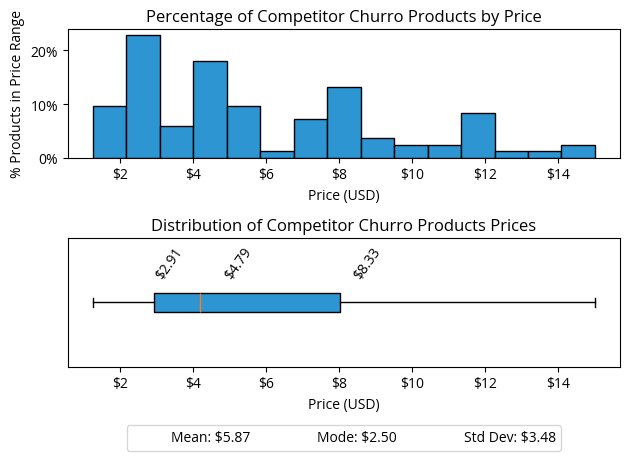

In [94]:

# portos_df = pd.read_csv("pricing files/portos_1.csv")
# sb_df = pd.read_csv("pricing files/starbucks_1.csv")
# shack_df = pd.read_csv("pricing files/shake_shack_2.csv")
# df = pd.concat([shack_df, sb_df, portos_df], ignore_index=True)

# df, food, dessert, drink, _ = classify_products("pricing files/product_dataset.csv")

df = pd.read_csv("pricing files/churro_products_dataset.csv")
food = np.ones(df.shape[0], dtype=bool)

# index_array = np.array(np.load("index_array.npy", allow_pickle=True), dtype=int)
# dessert = index_array == 2

# practice_data1, practice_df, num_bins = get_data_for_products(df, dessert, outlier_threshold=10)
threshold = 15
practice_data1 = np.append(df["Price"].values[food][(df["Price"].values[food] < threshold)], threshold)

# elmoro_df = pd.read_excel("pricing files/EL Moro Menu Pricing.xlsx")

# mask = (elmoro_df["Category"] == "Drinks") & (elmoro_df["Price"] < 20)
# practice_data2 = elmoro_df["Price"].values[mask]
title = "Churro Products"
filename = f'final_{title.lower()}_plot'

plot_pricing_data_hist(practice_data1, df.iloc[food], threshold, title, filename, just_for_fun=False)


In [16]:
ex = np.arange(10)

exbool = np.arange(10)[np.random.choice([True, False], 10)]
print(type(exbool[0]))
ex[exbool]

<class 'numpy.int32'>


array([1, 4, 5])

In [171]:
filename = "pricing files/product_dataset.csv"

df, entree_index_list, dessert_index_list, drink_index_list, multiple_groups_list = classify_products(filename)

# Entrees Data
outlier_threshold = 25
entree_pricing, entree_df = get_data_for_products(df, entree_index_list, outlier_threshold="choose")

# Desserts Data
outlier_threshold = 15
dessert_pricing, dessert_df = get_data_for_products(df, dessert_index_list, outlier_threshold)

# Drinks Data
outlier_threshold = 10
drink_pricing, drink_df = get_data_for_products(df, drink_index_list, outlier_threshold)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 5320 but corresponding boolean dimension is 1465

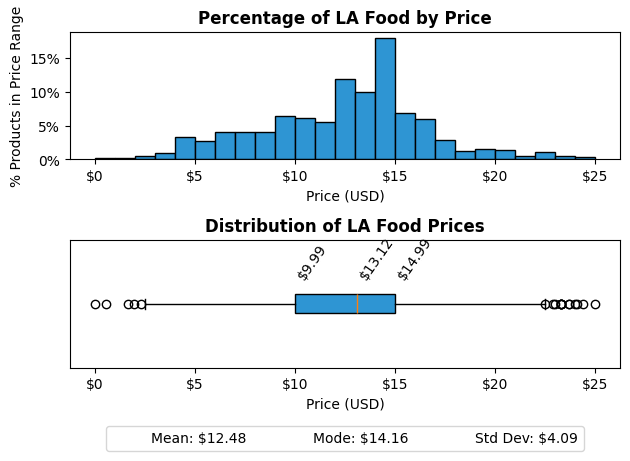

In [18]:
plot_pricing_data(entree_pricing, entree_df, 25, "Food", "food_plot.png")

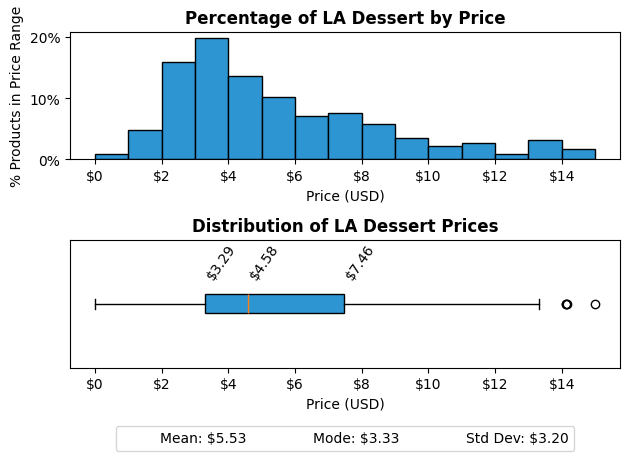

In [20]:
plot_pricing_data(dessert_pricing, dessert_df, 15, "Dessert", "dessert_plot")

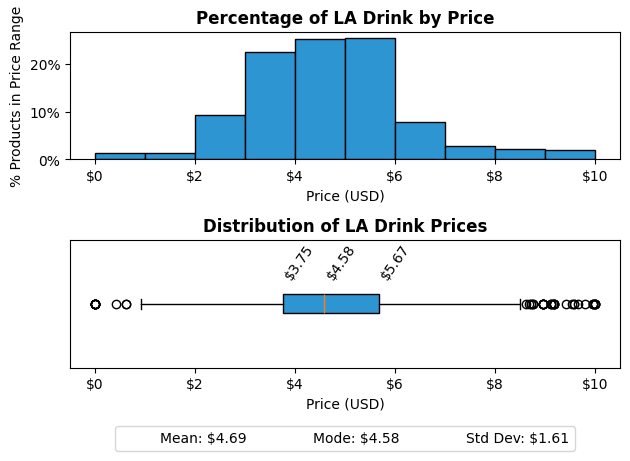

In [21]:
plot_pricing_data(drink_pricing, drink_df, 10, "Drink", "drink_plot")

# Code for colab

In [24]:
# from selenium import webdriver
# from selenium.webdriver import ActionChains
# from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.chrome.options import Options
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# import pandas as pd
# import time
# import re
# import numpy as np
# from tqdm import tqdm
# import requests
# import os
# from datetime import datetime, timedelta
# from dotenv import load_dotenv

# ############################################################################################################
# # Pricing Analysis 


# def wait_for_page_load(browser, timeout=10):   
#     """Wait for the page to load by checking the document.readyState.""" 
#     WebDriverWait(browser, timeout).until(
#         lambda x: x.execute_script("return document.readyState") == "complete"
#     )


# def find_element_by_text(text, tag='li', browser=None, wait=None, timeout=10):
#     """
#     Find an element by its text content.
    
#     Args:
#         text (str): The text content to look for.
#         tag (str): The tag name to filter (default is 'li').
#         browser (webdriver): The browser instance to use.
#         wait (WebDriverWait): The WebDriverWait instance.
#         timeout (int): Timeout period for waiting.

#     Returns:
#         WebElement or None: The found element or None if not found.
#     """
#     # Construct an XPath expression to find the tag with the specific text
#     xpath = f"//{tag}[text()='{text}']"

#     # Wait until the desired element is located or time out
#     try:
#         element = wait.until(EC.presence_of_element_located((By.XPATH, xpath)))
#         return element
#     except Exception as e:
#         print(f"Element with text '{text}' not found. Error: {e}")
#         return None


# def extract_product_info(store_name, browser, wait):
#     """Extract information about a product from a store page."""
    
#     wait_for_page_load(browser)
#     time.sleep(5)
    
#     li_elements = browser.find_elements(By.TAG_NAME, "li")
    
#     product_info_list = []
#     product_names = []
#     product_prices = []
    
#     for li_elt in li_elements:  # Loop through each category
#         if (li_elt.find_elements(By.TAG_NAME, "h3")  # Check if it contains food items and is not Featured Items
#             and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Artículos destacados" 
#             and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Featured items"):
            
#             category = li_elt.find_elements(By.TAG_NAME, "h3")[0].text
            
#             # Locate all matching elements using Selenium's find_elements
#             span_elements = li_elt.find_elements(By.TAG_NAME, "span")
#             price_pattern = r"^(USD ?|\$ ?)\d+\.\d{2}$"
#             review_pattern = r" \d+% \((\d+)\)"
                        
#             for index, element in enumerate(span_elements):
#                 price = element.text
#                 calories = None
#                 rating_percentage = None
#                 num_reviews = 0
                
#                 # Check if the current text begins with "USD" or "$"
#                 if price.startswith("USD") or price.startswith("$"):
#                     if not re.match(price_pattern, price):  # Check if the str matches the price pattern
#                         continue
                    
#                     # Convert price to float
#                     # Adjust for inflated delivery prices (ranges from 10-30% depending on the store so assume 20%)
#                     if price.startswith("USD "): 
#                         price = round(float(price[4:]) / 1.2, 2)
#                     else:
#                         price = round(float(price[4:]) / 1.2, 2)
                    
#                     # Get the previous element's text (if it exists)
#                     product_name = span_elements[index - 1].text if index > 0 else None
                    
#                     # Avoid duplicate products 
#                     if product_name in product_names:  # Skip if product name and price match 
#                         index = product_names.index(product_name)
#                         if price == product_prices[index]:
#                             continue
                    
#                     product_names.append(product_name)
#                     product_prices.append(price)
                        

#                     # Check if the next element is ' • \n'
#                     if index + 1 < len(span_elements) and span_elements[index + 1].text.strip() == '•':
                        
#                         if not re.match(review_pattern, span_elements[index + 2].text):
#                             rating_percentage = None
#                             num_reviews = 0
#                             calories = int(span_elements[index + 2].text.split()[0])
#                         else:
#                             # Get the next-next element's text
#                             reviews = span_elements[index + 2].text if index + 2 < len(span_elements) else None

#                             # Parse the reviews text
#                             reviews_split = reviews.split()
#                             rating_percentage = float(reviews_split[0][:-1])
#                             num_reviews = int(reviews_split[1][1:-1])
                            
#                             if index + 3 < len(span_elements) and span_elements[index + 3].text.strip() == '•':
#                                 calories = int(span_elements[index + 4].text.split()[0])
                        
#                         product_info_list.append([store_name, category, product_name, price, rating_percentage, num_reviews, calories])
#                     else:
#                         product_info_list.append([store_name, category, product_name, price, None, 0, None])
            
#     return product_info_list


# # Helper Function: Set up the browser for the extraction phase
# def setup_extraction(search_query, location, headless):
#     """Helper Function: Set up the browser for the extraction phase."""
    
#     # Initialize a `tqdm` object with a total of 10
#     setup_bar = tqdm(total=4, desc="Setting up the browser...")
            
#     # Set up the browser
#     options = Options()
#     if headless:
#         options.add_argument("--headless")
    
#     browser = webdriver.Chrome(options=options)
#     wait = WebDriverWait(browser, 10)
#     english = True

#     # Get the website URL from the environment variables
#     load_dotenv()
#     website_url = os.getenv("WEBSITE_URL")

#     # Open the specific website
#     browser.get(website_url)

#     # Check if the page is in English or Spanish
#     search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
#     placeholder = search_bar.get_attribute('placeholder')
#     if placeholder == "Ingresa la dirección de entrega":
#         english = False

#     setup_bar.update(1)

#     # Search bar for the location
#     wait.until(EC.presence_of_element_located((By.XPATH, '//*[@role="combobox"]')))
        
#     # Using XPath to select elements based on the role attribute
#     combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')

#     # Access the first found combobox element
#     if combobox_elements:
#         search_bar = combobox_elements[0]
        
#         # Input the search term into the search bar
#         search_bar.send_keys(location)
#         time.sleep(1)
        
#         # Press "Enter" to trigger the search
#         search_bar.send_keys(Keys.RETURN)
#     else:
#         raise Exception("First search bar not found.")

#     # Wait for the page to load
#     # TODO: Find a more robust way to wait for the page to load
#     time.sleep(3)
#     wait_for_page_load(browser)
#     time.sleep(3)
    
#     setup_bar.update(1)

#     # Second search bar for the search term
#     combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')
#     span_elements = browser.find_elements(By.TAG_NAME, 'span')
#     span = False

#     # Access the first found combobox element
#     if combobox_elements:
#         search_bar = combobox_elements[0]
        
#         # Input the search term into the search bar
#         search_bar.click()
#         time.sleep(1)
#     elif span_elements:  # Handles the case where the search bar is not a combobox
#         search_bar = span_elements[0]
        
#         # Input the search term into the search bar
#         search_bar.click()
#         time.sleep(1)
#         span = True
#     else:
#         raise Exception("Second search bar not found.")

#     # Search for restaurants
#     if english:  # Check if the language is set to English
#         restaurant_tab = find_element_by_text('Restaurants', tag='li', browser=browser, wait=wait)
#     else:
#         restaurant_tab = find_element_by_text('Restaurantes', tag='li', browser=browser, wait=wait)

#     if restaurant_tab:
#         restaurant_tab.click()
#         time.sleep(1)

#     # Input the search term into the search bar
#     search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
#     search_bar.send_keys(search_query)
#     search_bar.send_keys(Keys.RETURN)
    
#     setup_bar.update(1)

#     time.sleep(3)
#     wait_for_page_load(browser)
    
#     setup_bar.update(1)
#     setup_bar.close()
    
#     return browser, wait    


# def product_scraper(search_query, location, max_stores=50, file_storage=None, file_name=None, headless=True):
#     """Scrape the prices, ratings, and calories of food products based on a search query and location.
    
#     Parameters:
#         search_query (str): The search query to look for.
#         location (str): The location to search in.
#         file_storage (str): The method of storing the files as CSV. Options: None, "individual", "combined", "both".
#         file_name (str): The name of the file to store the data in as CSV. Must include if file_storage is not None.
#         headless (bool): Whether to run the browser in headless mode.
    
#     Returns:
#         pandas.DataFrame: A DataFrame containing the information about the products found.
#     """
    
#     # Check the input parameters
#     if max_stores < 1:
#         raise ValueError("max_stores must be greater than 0.")
#     if type(search_query) != str:
#         raise TypeError("search_query must be a string.")
#     if type(location) != str:
#         raise TypeError("location must be a string.")
#     if file_storage not in [None, "individual", "combined", "both"]:
#         raise ValueError("file_storage must be None, 'individual', 'combined', or 'both'.")
#     if file_storage and type(file_name) != str:
#         raise TypeError("file_name must be a string.")
#     if file_name and not file_storage:
#         raise ValueError("file_name must be included if file_storage is not None.")
#     if file_storage and not file_name:
#         raise ValueError("file_name must be included if file_storage is not None.")
#     if file_name:
#         if file_name.split(".")[-1] == "csv":
#             file_name = ".".join(file_name.split(".")[:-1])
    
#     # Set up the browser for the extraction phase
#     browser, wait = setup_extraction(search_query, location, headless)
    
#     # TODO: Add feature for multiple search queries HERE.
#     # For multiple locations, call the function multiple times with different locations. 
    
#     # Begin the extraction phase
#     main_url = browser.current_url  # Get the main URL to return to after visiting each store
#     store_names = []  # Store previous store names to avoid duplicates
#     all_stores_info_list = []  # Store all store information

#     # Get the list of stores to get the number of stores to iterate through
#     stores_list = browser.find_elements(By.TAG_NAME, 'h3')
    
#     if len(stores_list) < max_stores:
#         max_stores = len(stores_list)
    
#     processing_bar = tqdm(total=max_stores+1, desc="Extraction Phase")
    
#     duplicate_case = 2
    
#     if len(stores_list) > 3:
#         if (stores_list[0].text != stores_list[1].text 
#             and stores_list[1].text != stores_list[2].text 
#             and stores_list[2].text != stores_list[3].text):
#             if (stores_list[1].text != "" 
#                 and stores_list[2].text != "" 
#                 and stores_list[3].text != ""):
#                 duplicate_case = 1
#     else: 
#         duplicate_case = 1
        
    
        
#     # NOTE: There are multiple different page load possibilities. Some of them provide
#     # duplicate or empty h3 elements. This code is designed to handle those cases in a 
#     # way that will provide the expected number of stores each time.
#     for i in range(0, max_stores, duplicate_case):  # Loop through each store
        
#         # Update the processing_bar
#         processing_bar.update(1)
        
#         # Wait for the h3 element to be present
#         wait.until(EC.presence_of_element_located((By.TAG_NAME, 'h3')))
        
#         # Get the list of h3 elements again
#         stores_list = browser.find_elements(By.TAG_NAME, 'h3')
        
#         # Get the next h3 element to click on
#         store = stores_list[i]
#         store_name = store.text
        
#         # Skip if the h3 element is empty or if it is a duplicate
#         if stores_list[i] != '':
#             store = stores_list[i]
#             store_name = store.text
#         else:
#             store = stores_list[i+1]
#             store_name = store.text
        
#         store_names.append(store_name)
        
#         # Scroll to make the element visible in the viewport
#         ActionChains(browser).move_to_element(store).perform()

#         try:  # Handle cases where the store is intercepted by a popup
#             store.click()
#         except Exception as e:
#             ActionChains(browser).move_to_element(store).scroll_by_amount(0, 100).perform()
#             try:
#                 store.click()
#             except Exception as e:
#                 print(f"_____\nError clicking on store: {store_name}\nIteration: {i, len(store_names)}\nError: {e}\n_____")
#                 break  # Change this to continue once bug is fixed
        
#         # Extract information about the store
#         store_product_info_list = extract_product_info(store_name, browser, wait)
        
#         # Save the store information to a CSV file
#         if file_storage == "individual" or file_storage == "both":
#             try:  # Handle cases when it might overwrite a file
#                 # Create a DataFrame from the product info
#                 store_df = pd.DataFrame(store_product_info_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])

#                 # Save the DataFrame to a CSV file with UTF-8 encoding
#                 store_df.to_csv(f"pricing files/{file_name}_{store_name}.csv", index=False, encoding="utf-8")
#             except Exception as e:
#                 print(f"Error saving store information to CSV for {store_name}: {e}")
        
#         all_stores_info_list.extend(store_product_info_list)
        
#         time.sleep(3)
#         browser.back()
        
#         # Handle cases where the browser does not return to the main URL
#         if browser.current_url != main_url:
#             print(f"_____\nError returning to main URL for {store_name}\nIteration: {i, len(store_names)}\nURL: {browser.current_url}\n_____")
#             browser.get(main_url)
#             time.sleep(3)
            
                    
#     # Create a DataFrame from the product info
#     all_stores_df = pd.DataFrame(all_stores_info_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])

#     if file_storage == "combined" or file_storage == "both":
#         try:  # Handle cases when it might overwrite a file
#             # Save the DataFrame to a CSV file with UTF-8 encoding
#             all_stores_df.to_csv(f"pricing files/{file_name}.csv", index=False, encoding="utf-8")
#         except Exception as e:
#             print(f"Error saving all store information to CSV: {e}")
            
#     # Close the browser
#     browser.quit()
    
#     # Close the progress bar after completing all tasks
#     processing_bar.close()

#     return all_stores_df


# Trying to get urls instead of clicking

In [1]:

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time
import re
import numpy as np
from tqdm import tqdm
import os
from dotenv import load_dotenv
import dask
from dask import delayed, compute
from dask.diagnostics import ProgressBar


############################################################################################################
# Pricing Analysis 


def wait_for_page_load(browser, timeout=20):   
    """Wait for the page to load by checking the document.readyState.""" 
    WebDriverWait(browser, timeout).until(
        lambda x: x.execute_script("return document.readyState") == "complete"
    )


def find_element_by_text(text, tag='li', browser=None, wait=None, timeout=20):
    """
    Find an element by its text content.
    
    Args:
        text (str): The text content to look for.
        tag (str): The tag name to filter (default is 'li').
        browser (webdriver): The browser instance to use.
        wait (WebDriverWait): The WebDriverWait instance.
        timeout (int): Timeout period for waiting.

    Returns:
        WebElement or None: The found element or None if not found.
    """
    # Construct an XPath expression to find the tag with the specific text
    xpath = f"//{tag}[text()='{text}']"

    # Wait until the desired element is located or time out
    try:
        element = wait.until(EC.presence_of_element_located((By.XPATH, xpath)))
        return element
    except Exception as e:
        print(f"Element with text '{text}' not found. Error: {e}")
        return None


def extract_product_info(url, store_name, headless):
    """Extract information about a product from a store page."""
    
    options = Options()
    if headless:
        options.add_argument("--headless")
        
    browser = webdriver.Chrome(options=options)
    browser.get(url)
    
    try:
        wait_for_page_load(browser)
    except:
        print("Page load failed. Trying again...")
        
    # time.sleep(5)
    
    li_elements = browser.find_elements(By.TAG_NAME, "li")
    
    product_info_list = []
    product_names = []
    product_prices = []
    
    for li_elt in li_elements:  # Loop through each category
        if (li_elt.find_elements(By.TAG_NAME, "h3")  # Check if it contains food items and is not Featured Items
            and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Artículos destacados" 
            and li_elt.find_elements(By.TAG_NAME, "h3")[0].text != "Featured items"):
            
            category = li_elt.find_elements(By.TAG_NAME, "h3")[0].text
            
            # Locate all matching elements using Selenium's find_elements
            span_elements = li_elt.find_elements(By.TAG_NAME, "span")
            price_pattern = r"^(USD ?|\$ ?)\d+\.\d{2}$"
            review_pattern = r" \d+% \((\d+)\)"
                        
            for index, element in enumerate(span_elements):
                price = element.text
                calories = None
                rating_percentage = None
                num_reviews = 0
                
                # Check if the current text begins with "USD" or "$"
                if price.startswith("USD") or price.startswith("$"):
                    if not re.match(price_pattern, price):  # Check if the str matches the price pattern
                        continue
                                        
                    # Convert price to float
                    # Adjust for inflated delivery prices (ranges from 10-30% depending on the store so assume 20%)
                    if price.startswith("USD "): 
                        price = round(float(price[4:]) / 1.2, 2)
                    else:
                        price = round(float(price[1:]) / 1.2, 2)
                                            
                    # Get the previous element's text (if it exists)
                    product_name = span_elements[index - 1].text if index > 0 else None
                    
                    # Avoid duplicate products 
                    if product_name in product_names:  # Skip if product name and price match 
                        index = product_names.index(product_name)
                        if price == product_prices[index]:
                            continue
                    
                    product_names.append(product_name)
                    product_prices.append(price)
                        

                    # Check if the next element is ' • \n'
                    if index + 1 < len(span_elements) and span_elements[index + 1].text.strip() == '•':
                        
                        if not re.match(review_pattern, span_elements[index + 2].text):
                            rating_percentage = None
                            num_reviews = 0
                            calories = int(span_elements[index + 2].text.split()[0])
                        else:
                            # Get the next-next element's text
                            reviews = span_elements[index + 2].text if index + 2 < len(span_elements) else None

                            # Parse the reviews text
                            reviews_split = reviews.split()
                            rating_percentage = float(reviews_split[0][:-1])
                            num_reviews = int(reviews_split[1][1:-1])
                            
                            if index + 3 < len(span_elements) and span_elements[index + 3].text.strip() == '•':
                                calories = int(span_elements[index + 4].text.split()[0])
                        
                        product_info_list.append([store_name, category, product_name, price, rating_percentage, num_reviews, calories])
                    else:
                        product_info_list.append([store_name, category, product_name, price, None, 0, None])
                                            
    browser.quit()
            
    return product_info_list


# Helper Function: Set up the browser for the extraction phase
def setup_extraction(search_query, location, headless):
    """Helper Function: Set up the browser for the extraction phase."""
    
    # Initialize a `tqdm` object with a total of 10
    setup_bar = tqdm(total=4, desc="Setting up the browser...")
            
    # Set up the browser
    options = Options()
    if headless:
        options.add_argument("--headless")
    
    browser = webdriver.Chrome(options=options)
    wait = WebDriverWait(browser, 20)
    english = True

    # Get the website URL from the environment variables
    load_dotenv()
    website_url = os.getenv("WEBSITE_URL")

    # Open the specific website
    browser.get(website_url)

    # Check if the page is in English or Spanish
    search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
    placeholder = search_bar.get_attribute('placeholder')
    if placeholder == "Ingresa la dirección de entrega":
        english = False

    setup_bar.update(1)

    # Search bar for the location
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@role="combobox"]')))
        
    # Using XPath to select elements based on the role attribute
    combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')

    # Access the first found combobox element
    if combobox_elements:
        search_bar = combobox_elements[0]
        
        # Input the search term into the search bar
        search_bar.send_keys(location)
        time.sleep(1)
        
        # Press "Enter" to trigger the search
        search_bar.send_keys(Keys.RETURN)
    else:
        raise Exception("First search bar not found.")

    # Wait for the page to load
    # TODO: Find a more robust way to wait for the page to load
    time.sleep(3)
    wait_for_page_load(browser)
    time.sleep(3)
    
    setup_bar.update(1)

    # Second search bar for the search term
    combobox_elements = browser.find_elements(By.XPATH, '//*[@role="combobox"]')
    span_elements = browser.find_elements(By.TAG_NAME, 'span')

    # Access the first found combobox element
    if combobox_elements:
        search_bar = combobox_elements[0]
        
        # Input the search term into the search bar
        search_bar.click()
        time.sleep(1)
    elif span_elements:  # Handles the case where the search bar is not a combobox
        search_bar = span_elements[0]
        
        # Input the search term into the search bar
        search_bar.click()
        time.sleep(1)
    else:
        raise Exception("Second search bar not found.")

    # Search for restaurants
    if english:  # Check if the language is set to English
        restaurant_tab = find_element_by_text('Restaurants', tag='li', browser=browser, wait=wait)
    else:
        restaurant_tab = find_element_by_text('Restaurantes', tag='li', browser=browser, wait=wait)

    if restaurant_tab:
        restaurant_tab.click()
        time.sleep(1)

    # Input the search term into the search bar
    search_bar = browser.find_element(By.XPATH, '//*[@role="combobox"]')
    search_bar.send_keys(search_query)
    search_bar.send_keys(Keys.RETURN)
    
    setup_bar.update(1)

    time.sleep(3)
    wait_for_page_load(browser)
    
    setup_bar.update(1)
    setup_bar.close()
    
    return browser 


def product_scraper(search_query, location, max_stores=50, filename=None, headless=True, debug_mode=False):
    """Scrape the prices, ratings, and calories of food products based on a search query and location.
    
    Parameters:
        search_query (str): The search query to look for.
        location (str): The location to search in.
        filename (str): The name of the file to store the data in as CSV.
        headless (bool): Whether to run the browser in headless mode.
    
    Returns:
        pandas.DataFrame: A DataFrame containing the information about the products found.
    """
    
    # NOTE: There are multiple different page load possibilities. Some of them provide
    # duplicate or empty "h3" or "a" tags. This code is designed to handle those cases in a 
    # way that will provide the expected number of stores each time.
    
    # Check the input parameters
    if max_stores < 1:
        raise ValueError("max_stores must be greater than 0.")
    if type(search_query) != str:
        raise TypeError("search_query must be a string.")
    if type(location) != str:
        raise TypeError("location must be a string.")
    if filename:
        if filename.split(".")[-1] == "csv":
            filename = ".".join(filename.split(".")[:-1])
    
    # Set up the browser for the extraction phase
    browser = setup_extraction(search_query, location, headless)
    
    # TODO: Add feature for multiple search queries HERE.
    # For multiple locations, call the function multiple times with different locations. 
    
    # Begin the extraction phase
    store_names = []  # Store previous store names to avoid duplicates
    all_stores_info_list = []  # Store all store information

    # Get the list of stores to get the number of stores to iterate through
    stores_list = browser.find_elements(By.TAG_NAME, 'h3')
    
    if len(stores_list) < max_stores:
        max_stores = len(stores_list)
        
    # Get store names all at once by checking h3 elements    
    for store in stores_list:
        name = store.text
        if name != "" and name not in store_names:
            store_names.append(name)
    
    xpath_expression = '//a[@data-testid="store-card"]'
    store_urls_list = browser.find_elements(By.XPATH, xpath_expression)
    store_urls = []

    # Get the store URLs
    for store in store_urls_list:
        store_url = store.get_attribute('href')
        if store_url not in store_urls:
            store_urls.append(store_url)

    if debug_mode:  # Debugging store names and urls
        print(f"Number of Store names: {len(store_names)}")
        print(f"Number of Store URLs: {len(store_urls)}")
        
        for i in range(len(store_names)):  # Loop through each store
            print(f"Store Name: {store_names[i]}")
            print(f"Store URL: {store_urls[i]}")
            
    if len(store_names) != len(store_urls):  # Debugging the store names and URLs
        print(f"Number of store names and URLs do not match: {len(store_names), len(store_urls)}")
        
        try:
            for i in range(len(store_names)):  # Loop through each store
                print(f"Store Name: {store_names[i]}")
                print(f"Store URL: {store_urls[i]}")
                print("______________")
        except Exception as e:
            print(f"Error printing store names and URLs: {e}")
        print("store names: ", store_names)
        print("store urls: ", store_urls)
    
    # Wrap extract_product_info with Dask's delayed
    extract_product_info_dask = delayed(extract_product_info)
    
    # Create a list of delayed tasks
    tasks = [extract_product_info_dask(store_urls[i], store_names[i], headless) for i in range(max_stores)]
    
    # Compute the tasks in parallel
    with ProgressBar():
        results = compute(*tasks, scheduler='processes')
    
    # Aggregate results
    for result in results:
        all_stores_info_list.extend(result)
                    
    # Create a DataFrame from the product info
    all_stores_df = pd.DataFrame(all_stores_info_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])

    if filename:
        try:  # Handle cases when it might overwrite a file
            # Save the DataFrame to a CSV file with UTF-8 encoding
            all_stores_df.to_csv(f"pricing files/{filename}.csv", index=False, encoding="utf-8")
        except Exception as e:
            print(f"Error saving all store information to CSV: {e}")
            new_filename = generate_unique_filename(f"pricing files/{filename}.csv", ".csv")
            all_stores_df.to_csv(f"pricing files/{new_filename}.csv", index=False, encoding="utf-8")
            print(f"Saved with file name: {new_filename}")
            
    # Close the browser
    browser.quit()

    return all_stores_df


In [3]:

search_query = "Coffee Shop"
# location = "1524 Sunset Blvd, Los Angeles, CA 90026, United States"  # Echo Park
location = "941 Westwood Blvd, Los Angeles, CA 90024, USA"  # Westwood
max_stores = 1000  # Not Max Products, each store contains multiple products.
filename = "testing"
headless = True

final_stores_df = product_scraper(search_query, location, max_stores=max_stores, filename=filename, headless=headless)


Setting up the browser...:   0%|          | 0/4 [00:00<?, ?it/s]

Setting up the browser...: 100%|██████████| 4/4 [00:20<00:00,  5.10s/it]


[########################################] | 100% Completed | 273.76 s


In [11]:
# Number of stores
num_stores = final_stores_df['Store Name'].nunique()

# Number of products per store
num_products_per_store = final_stores_df.groupby('Store Name')['Product Name'].count()

print("Number of stores:", num_stores)
print("Number of products per store:")
print(num_products_per_store)

Number of stores: 72
Number of products per store:
Store Name
310 Coffee Company                              46
Alfred Coffee Westwood Village                  55
BJ's Restaurant & Brewhouse (Westwood #411)    166
Belwood Bakery Cafe (Brentwood)                 73
Bites (Wilshire)                                96
                                              ... 
Toasty's Breakfast Burritos - Gayley Ave        23
Western Bagel (West LA)                         52
Wingstop (10850 Le Conte Avenue)                41
Yummy's                                         94
dipnmix                                         13
Name: Product Name, Length: 72, dtype: int64


In [74]:
prod_names = final_stores_df["Product Name"].values
[print(prod_names[i]) for i in range(len(prod_names))]

Roasted Tortilla Soup
Ensalada
Asada Sope
Pinto Beans Sope
Carnitas Sope
Al Pastor Sope
Al Pastor Burrito
Asada Burrito
Pollo Burrito
Camaron Burrito
Carnitas Burrito
Vegetariano Burrito
Le Falta Burrito
Pescado Burrito
Asada Taco
Al Pastor Taco
Pescado Taco
Pollo a la Parrilla Taco
Camaron Taco
Pollo Mole Taco
Pollo Al Pastor
Carnitas Taco
Lengua Taco
Adobada Taco
Nopal Taco
Vegetariano Taco
Pinche Combination Plate
Gringo Taco
Not Nachos
Little Estiffy
Darkness Supreme
Pinche Tostada
Al Pastor Torta
Asada Torta
Vegetariana Torta
Carnitas Torta
Pescado Torta
Pollo Torta
Pollo Enchilada
Queso Enchilada
Camaron Enchilada
Pescado Enchilada
Pollo
Potato and Cheese
Carne
Chicken Quesadilla
Cheese Quesadilla
Carne Asada Quesadilla
Fried Quesadilla
Al Pastor Quesadilla
Camaron Quesadilla
Churros
Chips Salsa y Guacamole
Mexican Corn on the Cob
Chips y Salsa
Refried Beans
Mexican Rice
Guacamole
Nopales
Fountain Drinks
Aguas Frescas
Mexican Bottled Coke
Bottled Mexican Sodas
Pinche Bottled Wate

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [80]:
# Convert all product names to lowercase
final_adj_df = final_stores_df.copy()
final_adj_df['Product Name'] = final_stores_df['Product Name'].str.lower()

# Find product names that contain the word "churro"
churro_products = final_adj_df[final_adj_df['Product Name'].str.contains('churro')]

# Print the filtered dataframe
churro_products

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
51,Pinches Tacos (Westwood),Pinches Postres,churros,5.75,100.0,21,NaN
564,Tacos El Unico - Crenshaw,Churros,plain churros,1.50,NaN,0,NaN
565,Tacos El Unico - Crenshaw,Churros,bavarian cream churros,1.90,NaN,0,NaN
566,Tacos El Unico - Crenshaw,Churros,cajeta churros,1.90,NaN,0,NaN
567,Tacos El Unico - Crenshaw,Churros,6 mini churros,3.78,NaN,0,NaN
...,...,...,...,...,...,...,...
4246,Auntie Anne's & Cinnabon (10250 Santa Monica B...,Featured Products,churro chillatta®,7.49,NaN,0,NaN
4576,Wake Up Burrito,Desserts,"waffle churros (belgian waffle, cinnamon. sugar)",5.83,NaN,0,NaN
4578,Wake Up Burrito,Desserts,churro bites,7.49,NaN,0,NaN
4711,La Esquina,Dessert,churros with ice cream,5.00,100.0,22,NaN


In [82]:
# # Save the filtered dataframe to a CSV file
# churro_products.to_csv(f"pricing files/churro_products_dataset.csv", index=False, encoding="utf-8")


In [78]:
final_adj_df["Product Name"].values

array(['roasted tortilla soup', 'ensalada', 'asada sope', ..., ' • ',
       'homemade flan', 'deep fried ice cream'], dtype=object)

In [43]:
def save_csv(df, filename):
    """Save the DataFrame to a CSV file with a unique filename."""
    new_filename = generate_unique_filename(f"pricing files/{filename}", ".csv")
    df.to_csv(new_filename, index=False, encoding="utf-8")


def extract_url_info(url, store_name, headless, filename=None):
    """Extract information about a product from a store page."""
    product_list = extract_product_info(url, store_name, headless)
    product_df = pd.DataFrame(product_list, columns=['Store Name', 'Category', 'Product Name', 'Price', 'Rating', 'Number of Reviews', 'Calories'])
    
    if filename:
        save_csv(product_df, filename)
    
    return product_df

In [70]:
url = "https://www.ubereats.com/mx-en/store/shake-shack-century-city/dJeSVf4mSzGKHn8NBBiPKA?diningMode=DELIVERY"
starbucks = "https://www.ubereats.com/mx-en/store/starbucks-broxton-%26-weyburn/h0Ib4Mg9RIi9kTOwzA6n2g?diningMode=DELIVERY"
beanleaf = "https://www.ubereats.com/mx-en/store/the-coffee-bean-%26-tea-leaf-9541-w-pico-blvd/2jq8nIV2SXmkkr-XBjIdbQ?diningMode=DELIVERY"
store_name = "Shake Shack"
headless = True
filename = "shake_shack"

product_df = extract_url_info(url, store_name, headless, filename)

Original Price:  $11.79
Adjusted Price:  9.82
Final Price:  9.82
Original Price:  $9.59
Adjusted Price:  7.99
Final Price:  7.99
Original Price:  $12.99
Adjusted Price:  10.83
Final Price:  10.83
Original Price:  $11.79
Adjusted Price:  9.82
Final Price:  9.82
Original Price:  $11.79
Adjusted Price:  9.82
Final Price:  9.82
Original Price:  $11.99
Adjusted Price:  9.99
Final Price:  9.99
Original Price:  $15.99
Adjusted Price:  13.33
Final Price:  13.33
Original Price:  $8.99
Adjusted Price:  7.49
Final Price:  7.49
Original Price:  $9.39
Adjusted Price:  7.83
Final Price:  7.83
Original Price:  $11.39
Adjusted Price:  9.49
Final Price:  9.49
Original Price:  $14.19
Adjusted Price:  11.82
Final Price:  11.82
Original Price:  $6.99
Adjusted Price:  5.83
Final Price:  5.83
Original Price:  $11.99
Adjusted Price:  9.99
Final Price:  9.99
Original Price:  $13.89
Adjusted Price:  11.58
Final Price:  11.58
Original Price:  $11.39
Adjusted Price:  9.49
Final Price:  9.49
Original Price:  $7.1

In [72]:
product_df

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
0,Shake Shack,Burgers,Korean BBQ Burger,9.82,81.0,32,690.0
1,Shake Shack,Burgers,ShackBurger,7.99,88.0,1040,530.0
2,Shake Shack,Burgers,Avocado Bacon Burger,10.83,84.0,174,610.0
3,Shake Shack,Burgers,SmokeShack,9.82,90.0,222,610.0
4,Shake Shack,Burgers,Veggie Shack,9.82,90.0,11,630.0
5,Shake Shack,Burgers,'Shroom Burger,9.99,87.0,130,550.0
6,Shake Shack,Burgers,Shack Stack,13.33,91.0,85,800.0
7,Shake Shack,Burgers,Hamburger,7.49,87.0,136,400.0
8,Shake Shack,Burgers,Cheeseburger,7.83,86.0,399,470.0
9,Shake Shack,Burgers,Bacon Cheeseburger,9.49,85.0,110,500.0


In [97]:
starbucks = "https://www.ubereats.com/mx-en/store/starbucks-broxton-%26-weyburn/h0Ib4Mg9RIi9kTOwzA6n2g?diningMode=DELIVERY"
beanleaf = "https://www.ubereats.com/mx-en/store/the-coffee-bean-%26-tea-leaf-9541-w-pico-blvd/2jq8nIV2SXmkkr-XBjIdbQ?diningMode=DELIVERY"
name1 = "Starbucks"
name2 = "The Coffee Bean and Tea Leaf"
headless = True
filename1 = "starbucks"
filename2 = "beanleaf"

# product_df = extract_url_info(url, store_name, headless, filename)
sb_df = extract_url_info(starbucks, name1, headless, filename1)

In [73]:
headless = False
cbtl_df = extract_url_info(beanleaf, name2, headless, filename2)


In [48]:
product_df.head()

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
0,Shake Shack,Burgers,Korean BBQ Burger,65.83,81.0,32,690.0
1,Shake Shack,Burgers,ShackBurger,7.50,88.0,1040,530.0
2,Shake Shack,Burgers,Avocado Bacon Burger,82.50,84.0,174,610.0
3,Shake Shack,Burgers,SmokeShack,65.83,90.0,222,610.0
4,Shake Shack,Burgers,Veggie Shack,65.83,90.0,11,630.0


In [98]:
sb_df

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
0,Starbucks,Hot Coffees,Caffè Latte,4.62,None,0,100.0
1,Starbucks,Hot Coffees,Caffè Americano,3.96,None,0,5.0
2,Starbucks,Hot Coffees,Cappuccino,4.62,None,0,70.0
3,Starbucks,Hot Coffees,Caramel Macchiato,5.13,None,0,120.0
4,Starbucks,Hot Coffees,Caffè Mocha,5.13,None,0,200.0
...,...,...,...,...,...,...,...
146,Starbucks,Snacks & Sweets,SkinnyDipped Lemon Bliss Almonds,2.96,None,0,170.0
147,Starbucks,Snacks & Sweets,Siete Sea Salt Kettle Cooked Potato Chips,2.62,None,0,210.0
148,Starbucks,Snacks & Sweets,KIND® Salted Caramel & Dark Chocolate Nut Bar,2.29,None,0,200.0
149,Starbucks,Oatmeal & Yogurt,Rolled & Steel-Cut Oatmeal,4.29,None,0,160.0


In [74]:
cbtl_df

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories


In [83]:
crumbl = "https://www.ubereats.com/mx-en/store/crumbl-cookies-3810-midway-ave/Rug-wT2KWFafr3z_j-VNdQ?diningMode=DELIVERY"
portos = "https://www.ubereats.com/mx-en/store/portos-bakery-%26-cafe-burbank/Wul9cOfIT1eayi0_MCbjqQ?diningMode=DELIVERY&sc=SEARCH_SUGGESTION"
filename3 = "portos"
name3 = "Porto's Bakery & Cafe"

portos_df = extract_url_info(portos, name3, headless, filename3)

In [75]:
shack_df = product_df

In [25]:
portos_df = pd.read_csv("pricing files/portos_1.csv")
sb_df = pd.read_csv("pricing files/starbucks_1.csv")
shack_df = pd.read_csv("pricing files/shake_shack_2.csv")
main_df = pd.concat([shack_df, sb_df, portos_df], ignore_index=True)

In [101]:
main_df.iloc[100:200]

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
100,Starbucks,Starbucks Refreshers™ Beverages,Strawberry Açaí Starbucks Refreshers® Beverage,4.96,NaN,0,80.0
101,Starbucks,Starbucks Refreshers™ Beverages,Mango Dragonfruit Starbucks Refreshers® Beverage,4.96,NaN,0,70.0
102,Starbucks,Starbucks Refreshers™ Beverages,Pineapple Passionfruit Starbucks Refreshers® B...,4.96,NaN,0,80.0
103,Starbucks,Frappuccino® Blended Beverages,Caramel Frappuccino® Blended Beverage,5.79,NaN,0,260.0
104,Starbucks,Frappuccino® Blended Beverages,Matcha Crème Frappuccino® Blended Beverage,5.79,NaN,0,300.0
...,...,...,...,...,...,...,...
195,Starbucks,Snacks & Sweets,Madeleines,2.46,NaN,0,220.0
196,Starbucks,Snacks & Sweets,Peter Rabbit™ Organics Strawberry Banana,2.29,NaN,0,80.0
197,Starbucks,Snacks & Sweets,SkinnyDipped Dark Chocolate Cocoa Almonds,2.96,NaN,0,170.0
198,Starbucks,Snacks & Sweets,SkinnyDipped Lemon Bliss Almonds,2.96,NaN,0,170.0


In [96]:
sb_df

,Store Name,Category,Product Name,Price,Rating,Number of Reviews,Calories
0,Starbucks,Hot Coffees,Caffè Latte,4.17,None,0,100.0
1,Starbucks,Hot Coffees,Caffè Americano,4.17,None,0,5.0
2,Starbucks,Hot Coffees,Cappuccino,4.17,None,0,70.0
3,Starbucks,Hot Coffees,Caramel Macchiato,4.17,None,0,120.0
4,Starbucks,Hot Coffees,Caffè Mocha,4.17,None,0,200.0
...,...,...,...,...,...,...,...
147,Starbucks,Snacks & Sweets,Siete Lime Grain Free Tortilla Chips,4.17,None,0,130.0
148,Starbucks,Snacks & Sweets,Siete Sea Salt Kettle Cooked Potato Chips,4.17,None,0,210.0
149,Starbucks,Snacks & Sweets,KIND® Salted Caramel & Dark Chocolate Nut Bar,4.17,None,0,200.0
150,Starbucks,Oatmeal & Yogurt,Rolled & Steel-Cut Oatmeal,4.17,None,0,160.0


In [27]:
np.save("main_data", main_df)

In [26]:
# portos_df = pd.read_csv("pricing files/portos_1.csv")
# sb_df = pd.read_csv("pricing files/starbucks_1.csv")
# shack_df = pd.read_csv("pricing files/shake_shack_2.csv")
# main_df = pd.concat([shack_df, sb_df, portos_df], ignore_index=True)

import numpy as np
import pandas as pd

# Load the numpy array from the file
main_data = np.load('main_data.npy')

# Convert the numpy array to a DataFrame
main_df = pd.DataFrame(main_data)

index_arr = np.zeros_like(main_df["Product Name"].values)

for i, row in enumerate(main_df[["Product Name", "Price"]].iloc):
    print(row)
    user_input_int = None
    while user_input_int is None:
        try:
            user_input = input(f"{row}\n0 for NA, 1 for Savory, 2 for Dessert, 3 for Drink: ")
            user_input_int = int(user_input)
        except:
            if user_input == "exit":
                break
            user_input_int = None
            
    index_arr[i] = user_input

np.save("index_array", index_arr)
    
food = index_arr == 1
dessert = index_arr == 2
drink = index_arr == 3

Product Name    Korean BBQ Burger
Price                        9.82
Name: 0, dtype: object
Product Name    ShackBurger
Price                  7.99
Name: 1, dtype: object
Product Name    Avocado Bacon Burger
Price                          10.83
Name: 2, dtype: object
Product Name    SmokeShack
Price                 9.82
Name: 3, dtype: object
Product Name    Veggie Shack
Price                   9.82
Name: 4, dtype: object
Product Name    'Shroom Burger
Price                     9.99
Name: 5, dtype: object
Product Name    Shack Stack
Price                 13.33
Name: 6, dtype: object
Product Name    Hamburger
Price                7.49
Name: 7, dtype: object
Product Name    Cheeseburger
Price                   7.83
Name: 8, dtype: object
Product Name    Bacon Cheeseburger
Price                         9.49
Name: 9, dtype: object
Product Name    Roadside Double
Price                     11.82
Name: 10, dtype: object
Product Name    Grilled Cheese
Price                     5.83
Name: 11, dt

In [11]:
print(index_arr)
food = index_arr == 1
dessert = index_arr == 2
drink = index_arr == 3


NameError: name 'index_arr' is not defined

In [112]:
food_df = main_df[food]
dessert_df = main_df[dessert]
drink_df = main_df[drink]

In [150]:
practice_data, practice_df, num_bins = get_data_for_products(main_df, food, outlier_threshold="choose")

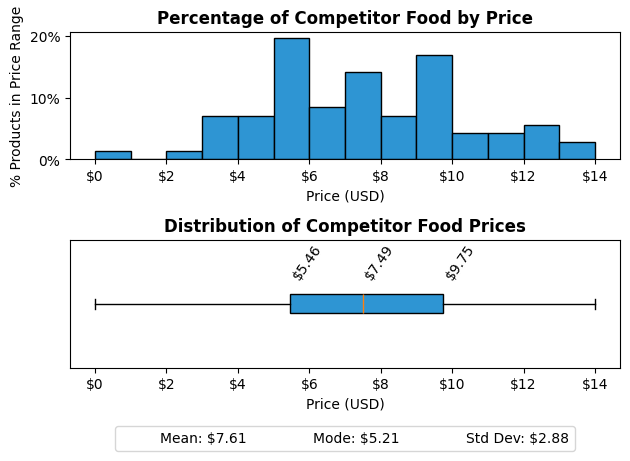

In [151]:
title = "Food"
filename = 'food_pricing_514'

plot_pricing_data(practice_data, practice_df, num_bins, title, filename)


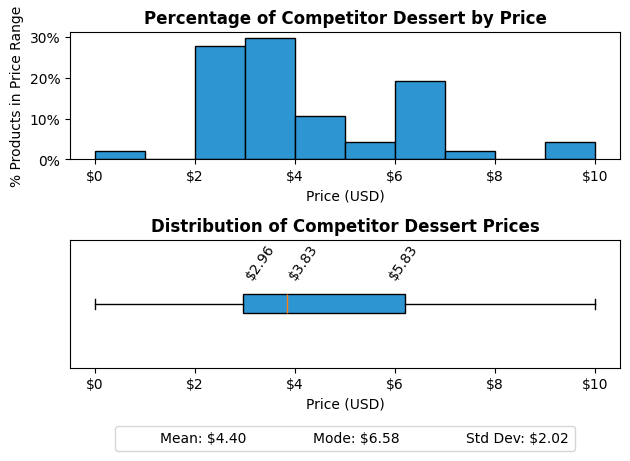

In [139]:
num_bins = None
title = "Dessert"
filename = 'dessert_pricing_514'

plot_pricing_data(practice_data, practice_df, num_bins, title, filename)


In [145]:
print(num_bins)

7.0


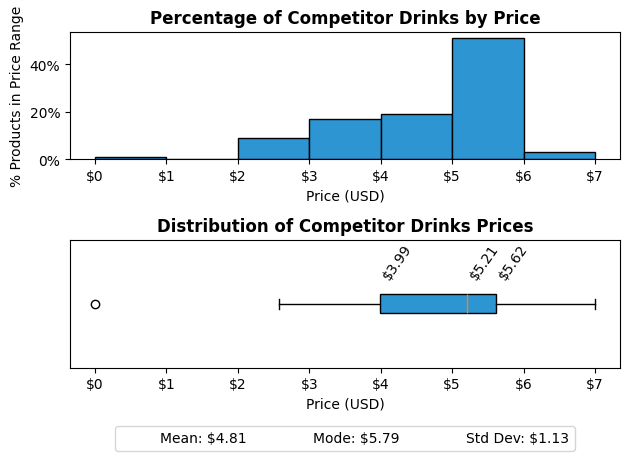

In [148]:
title = "Drinks"
filename = 'drink_pricing_514'

plot_pricing_data(practice_data, practice_df, num_bins, title, filename)
